# Stock Price Prediction Modeling

This notebook focuses on predicting target asset behavior using peer features as predictors.

In [47]:

import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from src.data_loader import StockDataLoader
from src.features import FeatureEngineer

In [48]:
# Add logging configuration
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)
# Load data and config
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
all_features = pd.read_pickle('../data/processed/all_features.pkl')

# Get target and peer features
target_symbol = config['target_symbol']
peer_symbols = config['peer_symbols']

# Split into target (y) and predictors (X)
target_columns = [col for col in all_features.columns if col.startswith(f'{target_symbol}_')]

# Define base features that might leak future information
base_leakage_features = [
    'Close',
    'High',
    'Low',
    'Open',
    'Volume',
    'Adj Close'
]

# Create leakage features list for all symbols
leakage_features = []
for symbol in [target_symbol] + peer_symbols:
    for feature in base_leakage_features:
        leakage_features.append(f'{symbol}_{feature}')

# Log leakage features for verification
logger.info("Leakage features being excluded:")
for feature in sorted(leakage_features):
    logger.info(f"  - {feature}")

# Get safe target features (technical indicators only)
safe_target_features = [col for col in target_columns 
                       if col not in leakage_features]

# Get peer features (excluding leakage features)
peer_columns = [col for col in all_features.columns 
                if not col.startswith(f'{target_symbol}_') 
                and col not in leakage_features]

# Create two feature sets
X_peers_only = all_features[peer_columns]
X_with_target = all_features[peer_columns + safe_target_features]

# Select which feature set to use
use_target_features = True  # Set to False to exclude target features
X = X_with_target if use_target_features else X_peers_only

y = all_features[f'{target_symbol}_Close']  # Using Close price as target

# Create train/test split using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



2025-05-31 19:29:09,477 - INFO - Leakage features being excluded:
2025-05-31 19:29:09,484 - INFO -   - AAPL_Adj Close
2025-05-31 19:29:09,490 - INFO -   - AAPL_Close
2025-05-31 19:29:09,491 - INFO -   - AAPL_High
2025-05-31 19:29:09,492 - INFO -   - AAPL_Low
2025-05-31 19:29:09,496 - INFO -   - AAPL_Open
2025-05-31 19:29:09,499 - INFO -   - AAPL_Volume
2025-05-31 19:29:09,501 - INFO -   - ADBE_Adj Close
2025-05-31 19:29:09,502 - INFO -   - ADBE_Close
2025-05-31 19:29:09,503 - INFO -   - ADBE_High
2025-05-31 19:29:09,504 - INFO -   - ADBE_Low
2025-05-31 19:29:09,505 - INFO -   - ADBE_Open
2025-05-31 19:29:09,506 - INFO -   - ADBE_Volume
2025-05-31 19:29:09,508 - INFO -   - AMZN_Adj Close
2025-05-31 19:29:09,517 - INFO -   - AMZN_Close
2025-05-31 19:29:09,535 - INFO -   - AMZN_High
2025-05-31 19:29:09,538 - INFO -   - AMZN_Low
2025-05-31 19:29:09,541 - INFO -   - AMZN_Open
2025-05-31 19:29:09,545 - INFO -   - AMZN_Volume
2025-05-31 19:29:09,549 - INFO -   - CRM_Adj Close
2025-05-31 19:29

2025-05-31 19:33:09,543 - INFO - Starting hyperparameter tuning...


Fitting 5 folds for each of 25 candidates, totalling 125 fits


2025-05-31 19:33:51,494 - INFO - Best parameters found: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.9}
2025-05-31 19:33:51,495 - INFO - Best cross-validation MSE: 247.4071


[0]	train-rmse:15.62433	test-rmse:34.33870
[1]	train-rmse:13.93546	test-rmse:33.58002
[2]	train-rmse:12.55153	test-rmse:32.65023
[3]	train-rmse:11.16165	test-rmse:30.98355
[4]	train-rmse:10.00145	test-rmse:30.07026
[5]	train-rmse:9.11933	test-rmse:29.72387
[6]	train-rmse:8.23385	test-rmse:28.50107
[7]	train-rmse:7.38350	test-rmse:27.54956
[8]	train-rmse:6.65279	test-rmse:27.02713
[9]	train-rmse:6.05157	test-rmse:26.57339
[10]	train-rmse:5.53044	test-rmse:25.87336
[11]	train-rmse:5.06910	test-rmse:25.37436
[12]	train-rmse:4.65566	test-rmse:25.15493
[13]	train-rmse:4.31121	test-rmse:24.62495
[14]	train-rmse:4.04282	test-rmse:24.17581


c:\Users\Kenrm\repositories\stock-prediction-ml\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:33:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[15]	train-rmse:3.76638	test-rmse:23.91409
[16]	train-rmse:3.54453	test-rmse:23.34358
[17]	train-rmse:3.36195	test-rmse:23.27570
[18]	train-rmse:3.17569	test-rmse:23.10387
[19]	train-rmse:3.02234	test-rmse:22.89997
[20]	train-rmse:2.87613	test-rmse:22.72804
[21]	train-rmse:2.75288	test-rmse:22.41365
[22]	train-rmse:2.63131	test-rmse:22.27389
[23]	train-rmse:2.52512	test-rmse:21.99220
[24]	train-rmse:2.43197	test-rmse:21.80410
[25]	train-rmse:2.36453	test-rmse:21.75315
[26]	train-rmse:2.28903	test-rmse:21.67979
[27]	train-rmse:2.21233	test-rmse:21.61394
[28]	train-rmse:2.16479	test-rmse:21.43629
[29]	train-rmse:2.10594	test-rmse:21.44993
[30]	train-rmse:2.05253	test-rmse:21.41624
[31]	train-rmse:1.99381	test-rmse:21.46845
[32]	train-rmse:1.95872	test-rmse:21.46022
[33]	train-rmse:1.92360	test-rmse:21.43233
[34]	train-rmse:1.87904	test-rmse:21.40556
[35]	train-rmse:1.83538	test-rmse:21.37614
[36]	train-rmse:1.78501	test-rmse:21.40636
[37]	train-rmse:1.75585	test-rmse:21.40672
[38]	train-

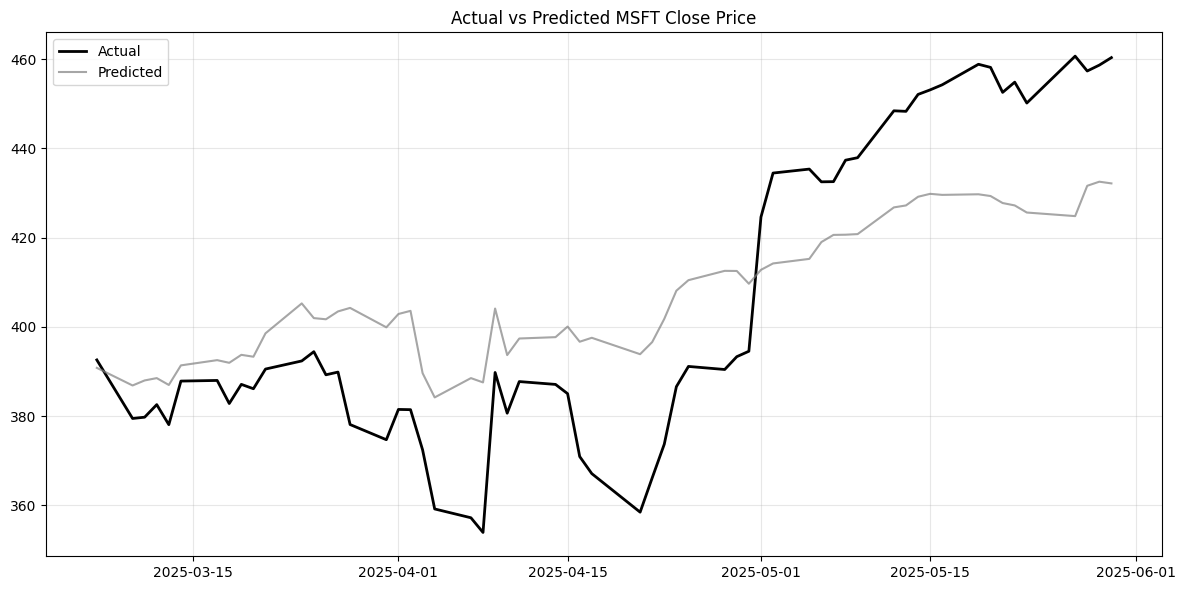

In [ ]:
# Convert data to DMatrix format with feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=list(X.columns))
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=list(X.columns))

# Define parameter space for tuning
param_space = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Initialize RandomizedSearchCV with reduced parallelism
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=1  # Prevent nested parallelism
    ),
    param_distributions=param_space,
    n_iter=25,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=4,  # Limit parallel jobs
    verbose=2,
    random_state=42
)

# Fit RandomizedSearchCV
logger.info("Starting hyperparameter tuning...")
random_search.fit(X_train_scaled, y_train)
# Log best parameters and score
logger.info(f"Best parameters found: {random_search.best_params_}")
logger.info(f"Best cross-validation MSE: {-random_search.best_score_:.4f}")

# Train final model with best parameters
best_params = random_search.best_params_
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
})

# Convert data to DMatrix format with feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=list(X.columns))
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=list(X.columns))

# Train model with best parameters
model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=True
)

# Make predictions
y_pred = model.predict(dtest)

# Save predictions
import os
os.makedirs('../data/processed', exist_ok=True)
pd.Series(y_pred, index=y_test.index).to_pickle('../data/processed/predictions.pkl')


Mean Squared Error: 427.1883
R-squared Score: 0.6245


C:\Users\Kenrm\AppData\Local\Temp\ipykernel_26296\1523635905.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


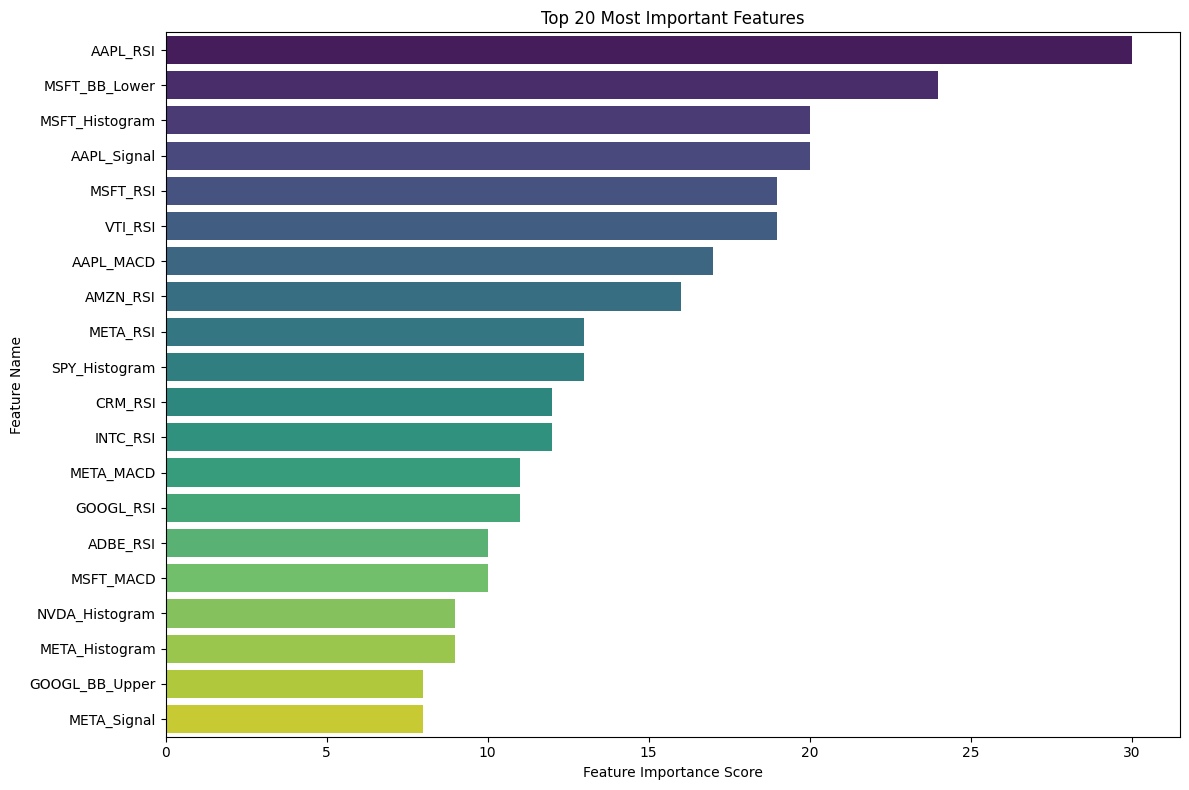


Top 10 Most Important Features:
       feature  importance
      AAPL_RSI        30.0
 MSFT_BB_Lower        24.0
MSFT_Histogram        20.0
   AAPL_Signal        20.0
      MSFT_RSI        19.0
       VTI_RSI        19.0
     AAPL_MACD        17.0
      AMZN_RSI        16.0
      META_RSI        13.0
 SPY_Histogram        13.0

Sentiment features account for 0.00% of total feature importance


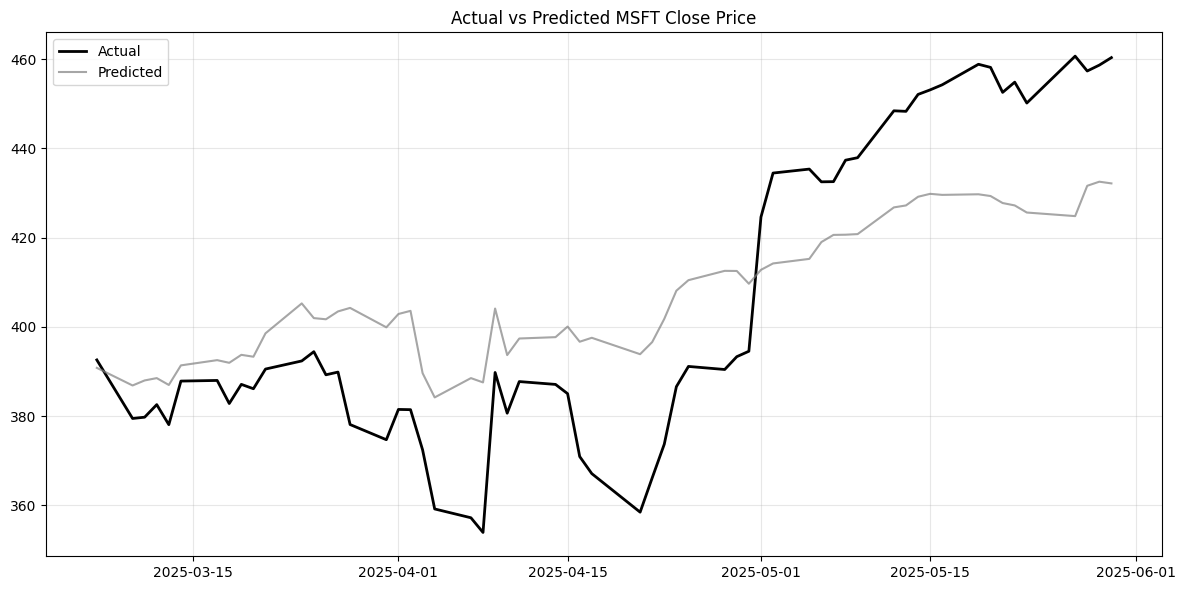

In [56]:

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared Score: {r2:.4f}')

# Feature importance with proper labels
importance_dict = model.get_score(importance_type='weight')
importance_df = pd.DataFrame(
    list(importance_dict.items()),
    columns=['feature', 'importance']
)
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
n_features = min(20, len(importance_df))  # Show top 20 features
sns.barplot(
    data=importance_df.head(n_features),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title(f'Top {n_features} Most Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# Print detailed feature importance
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Calculate percentage of importance for sentiment features
sentiment_features = importance_df[importance_df['feature'].str.contains('sentiment', case=False)]
sentiment_importance = sentiment_features['importance'].sum() / importance_df['importance'].sum() * 100

print(f"\nSentiment features account for {sentiment_importance:.2f}% of total feature importance")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, color='black', linestyle='-', label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, color='gray', linestyle='-', label='Predicted', alpha=0.7)
plt.title(f'Actual vs Predicted {target_symbol} Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()